In [ ]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess the data
u_data_path = '/content/u.data'
movie_data_path = '/content/u.item'

# Columns in the datasets
u_data_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown',
                 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                 'Thriller', 'War', 'Western']

# Load datasets
u_data = pd.read_csv(u_data_path, sep='\t', names=u_data_columns)
movies = pd.read_csv(movie_data_path, sep='|', encoding='latin-1', names=movie_columns, usecols=['movie_id', 'title'])

# Sort by timestamp and create sequences of user interactions
sequence_length = 5
user_group = u_data.groupby('user_id').apply(lambda x: x.sort_values(["timestamp"], ascending = True)).reset_index(drop=True)
sequences = user_group.groupby('user_id')['movie_id'].apply(lambda x: [x.values[i:i + sequence_length].tolist() for i in range(len(x) - sequence_length + 1)])

# Prepare inputs and labels
inputs, labels = [], []
for user_id, user_seqs in sequences.items():
    for seq in user_seqs:
        inputs.append(seq[:-1])  # All but the last
        labels.append(seq[-1])   # Last element

# Convert to array
inputs_array = np.array(inputs)
labels_array = np.array(labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, labels_array, test_size=0.2, random_state=42)

# Get the number of unique movies
num_movies = u_data['movie_id'].nunique()

# Build the LSTM model with modifications
model = Sequential()
model.add(Embedding(input_dim=num_movies + 1, output_dim=50, input_length=sequence_length - 1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_movies + 1, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# Train the model with modifications
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=128)

# Function to make movie recommendations
def recommend_movies(user_id, num_recommendations=5):
    user_data = u_data[u_data['user_id'] == user_id]
    recent_movies = user_data.sort_values(by='timestamp', ascending=False)['movie_id'].values[:sequence_length - 1]

    recent_movies_input = np.array([recent_movies])
    predicted_probs = model.predict(recent_movies_input)
    predicted_movie_ids = np.argsort(-predicted_probs[0])

    recommended_movies = []
    for predicted_movie_id in predicted_movie_ids:
        if predicted_movie_id in movies['movie_id'].values and len(recommended_movies) < num_recommendations:
            recommended_movie_title = movies[movies['movie_id'] == predicted_movie_id]['title'].values[0]
            recommended_movies.append(recommended_movie_title)

    return recommended_movies if recommended_movies else "No suitable recommendations found"

# Example usage
user_id_to_recommend = 1
recommended_movies = recommend_movies(user_id_to_recommend, num_recommendations=5)
print(f"Movies recommended for User {user_id_to_recommend}: {recommended_movies}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 50)             84150     
                                                                 
 lstm (LSTM)                 (None, 4, 100)            60400     
                                                                 
 dropout (Dropout)           (None, 4, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1683)              8

In [4]:
def calculate_ranking_metrics(predictions, ground_truth, k=10):
    mrr, ndcg = 0, 0
    for pred, true in zip(predictions, ground_truth):
        if true in pred[:k]:
            rank = pred.index(true) + 1
            mrr += 1 / rank
            ndcg += 1 / np.log2(rank + 1)
        else:
            rank = k + 1

    return mrr / len(predictions), ndcg / len(predictions)

# Predictions
y_pred = model.predict(X_test)
predicted_indices = np.argsort(-y_pred, axis=1)

# Convert predictions to lists of movie IDs
top_k_predictions = []
for row in predicted_indices:
    top_k_predictions.append(row[:10].tolist())  # Top 10 predictions

# Calculate Ranking Metrics
mrr, ndcg = calculate_ranking_metrics(top_k_predictions, y_test, k=10)

# For Precision, Recall, F1-Score, consider only the top prediction
binary_y_pred = [pred[0] == true for pred, true in zip(top_k_predictions, y_test)]
binary_y_true = [1] * len(y_test)  # Ground truth is always the actual movie watched

precision = precision_score(binary_y_true, binary_y_pred)
recall = recall_score(binary_y_true, binary_y_pred)
f1 = f1_score(binary_y_true, binary_y_pred)

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}, MRR: {mrr}, nDCG: {ndcg}")


602/602 [==============================] - 4s 6ms/step
Precision: 1.0, Recall: 0.015068066091655409, F1-Score: 0.02968877968877969, MRR: 0.03887128061242157, nDCG: 0.05809075570673336


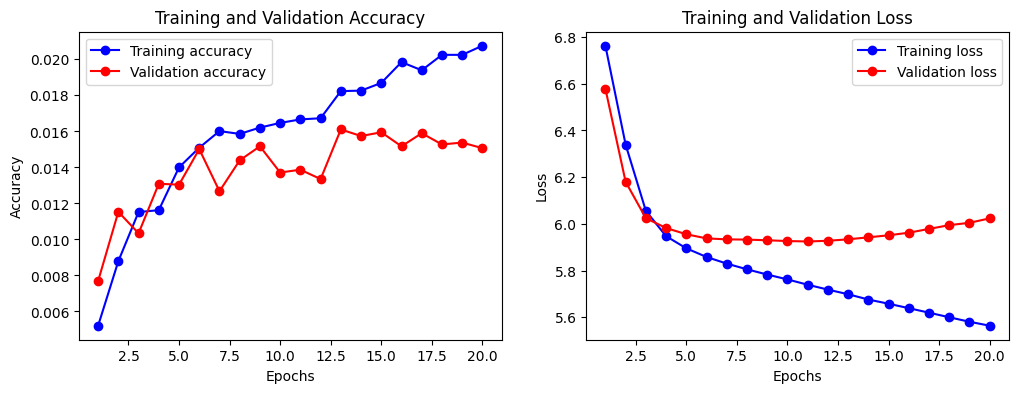

In [6]:
import matplotlib.pyplot as plt

# Access the history to get training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [7]:
!pip install pydot
!pip install graphviz


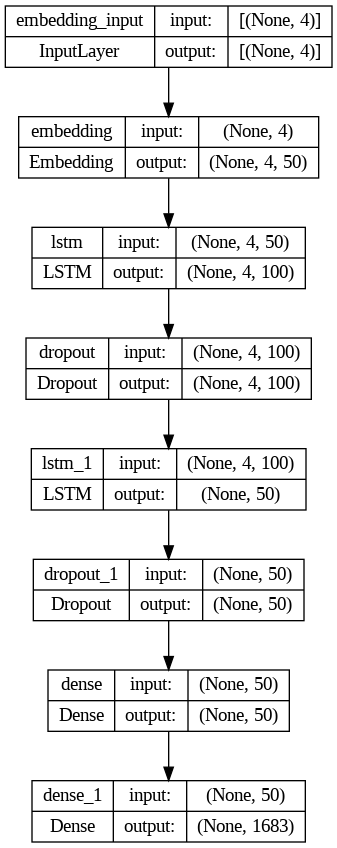

In [8]:
from tensorflow.keras.utils import plot_model

#sequential model image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
